# Requirements

In [1]:
import matplotlib.pyplot as plt
import numpy as np

We will compare two implementations for calculating the Julia set.  One in pure Python, the other using numpy.  Which will have the best performance?

The Julia set is computed by iterating over points in the complex plane, either till their norm exceeds 2, or the number of iterations exceeds 255.  The formula is
$$
z_{n + 1} = z_n^2 + c
$$

# Pure Python implementation

We start by defining a function that computes the number of iterations for a given point $z$ in the complex plane and a complex constant $c$.

In [2]:
def julia_set_iteration(z, c):
    i = 0
    while i < 255 and abs(z) < 2.0:
        z = z**2 + c
        i += 1
    return i

Next, we write a function to iterate over $n$ points in the complex plane in the interaval ${\rm re}(z) \in [-1.8, 1.8]$  and ${\rm im}(z) \in [-1.8, 1.8]$ given the constant $c$.

In [3]:
def julia_set(n, c):
    result = np.empty((n, n), dtype=np.uint8)
    delta = 2.0*1.8/n
    for i in range(n):
        z_re = -1.8 + i*delta
        for j in range(n):
            z_im = -1.8 + j*delta
            result[i, j] = julia_set_iteration(complex(z_re, z_im), c)
    return result

Verify the result of the computation by visualization.

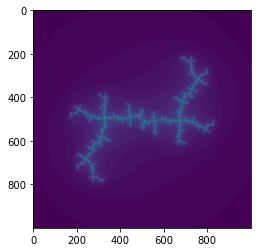

In [17]:
plt.imshow(julia_set(1000, 0.4 + 0.6j));

Now lets time this for a $1000 \times 1000$ array.

In [6]:
%timeit julia_set(1000, 0.4 + 0.6j)

960 ms ± 4.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Note: we're not cheating here, the numpy array is just to store values conveniently.

# Inlining

However, perhaps we loose time due to excessive function calls, so lets inline the while-loop.

In [14]:
def julia_set_inline(n, c):
    result = np.empty((n, n), dtype=np.uint8)
    delta = 2.0*1.8/n
    for i in range(n):
        z_re = -1.8 + i*delta
        for j in range(n):
            z_im = -1.8 + j*delta
            z = complex(z_re, z_im)
            result[i, j] = 0
            while result[i, j] < 255 and abs(z) < 2.0:
                z = z**2 + c
                result[i, j] += 1
    return result

In [15]:
%timeit julia_set_inline(1000, 0.4 + 0.6j)

13.2 s ± 68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This is quite horrifying.

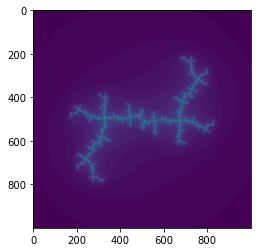

In [16]:
plt.imshow(julia_set_inline(1000, 0.4 + 0.6j));

This takes longer, so we should wonder why?  If we introduce a temporary variable that is updated in each iteration we can see what the influence is.

In [9]:
def julia_set_inline_no_conv(n, c):
    result = np.empty((n, n), dtype=np.uint8)
    delta = 2.0*1.8/n
    for i in range(n):
        z_re = -1.8 + i*delta
        for j in range(n):
            z_im = -1.8 + j*delta
            z = complex(z_re, z_im)
            nr_iters = 0
            while nr_iters < 255 and abs(z) < 2.0:
                z = z**2 + c
                nr_iters += 1
            result[i, j] = nr_iters
    return result

In [10]:
%timeit julia_set_inline_no_conv(1000, 0.4 + 0.6j)

981 ms ± 24.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


There is something rotten in the kingdom of Denmark, i.e., numpy.  Using numpy is in fact slowing down the execution.  The problem is type conversions between Python and numpy types.

# Conclusion

numpy is clearly not a panacea, we have to take into account type conversion tussen Python native and numpy types.